# Top level imports

In [1]:
import os
from pathlib import Path
import re

from fastai.vision.core import *
from fastai.vision.all import *

# Set up top level variables

In [2]:
# Path to our data
path = Path('./data')
path_hr = path/'clean'
path_lr = path/'tattoo'

# Training batch size, tune this based on the amount of memory
batch_size = 4
# Lets get the largest image we can fit in memory with a reasonable batch size
image_size = (640,480) #512 #128
#image_size = (320,240)

# TODO - what do we need to tune here?
wd, y_range, loss_gen = 1e-3, (-3., 3.), MSELossFlat()

# Where we should save our in-process model
callback_saved_model = Path("./callback_saved_model")
every_epoch=10
print(f"Temp model saving in {callback_saved_model.parent.resolve()} / {os.path.basename(callback_saved_model)}")

# Control for the number of epocs to run
epocs = 300
start_epoch=0

Temp model saving in /home/kozobot/deinked / callback_saved_model


# DataBlock

In [3]:
# get_y function
# Note: this function will need to be recreated when the model is loaded for predictions
def _get_y(x):
    return path_hr/x.name

# Helper method to create our datablock to load training data
def get_dls(bs:int, size:int):
  dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=get_image_files,
                   get_y = _get_y,
                   splitter=RandomSplitter(),
                   item_tfms=Resize(
                       size, resamples=(Image.BILINEAR, Image.NEAREST),
                       method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
                   batch_tfms=[#*aug_transforms(max_zoom=2.),
                               Normalize.from_stats(*imagenet_stats)])
  dls = dblock.dataloaders(path_lr, bs=bs, path=path, num_workers=0)
  dls.c = 3 # For 3 channel image
  return dls

# Pre-Trained Generator

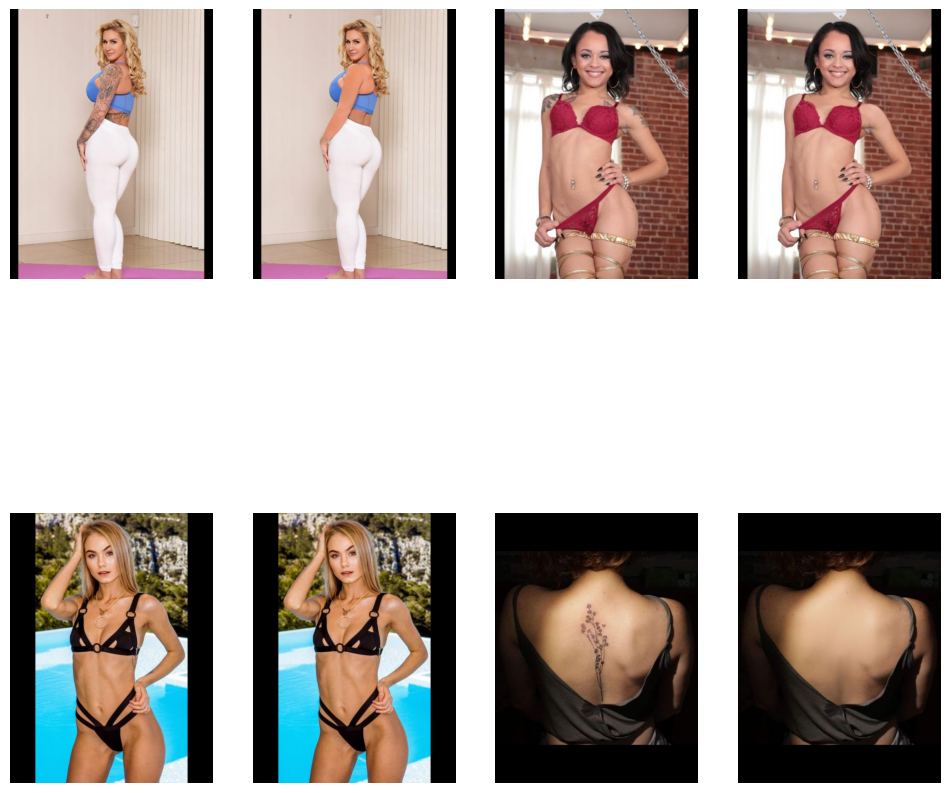

In [4]:
# Load our training data
dls_gen = get_dls(batch_size, image_size) 
dls_gen.show_batch(max_n=4, figsize=(12,12))

In [5]:
# For our backbone
#bbone = resnet34  
bbone = xresnet34_deeper # clear images slightly faded tatts about 7 sec per run
#bbone = resnet50 
#bbone = resnet18 
#bbone = squeezenet1_0 # blue pixelated; about 4 sec per run
#bbone = densenet121 # ran out of mem
#bbone = vgg16_bn # purple pixelated; about 5 sec per run
#bbone = vgg19_bn # blurry images with faded tatts; about 5 sec per run
#bbone = alexnet # pink blocks then blank; about 4 sec per run
def create_gen_learner():
    basename = os.path.basename(callback_saved_model)
    fname = callback_saved_model.parent.resolve()
    
    #cnn_learner??
    learner = unet_learner(dls_gen, bbone, 
                           path=fname,
                           loss_func=loss_gen,
                           blur=True, 
                           norm_type=NormType.Weight,
                           self_attention=True,
                           y_range=y_range,
                           cbs=[
                               # Set things up so that we can resume a crashed training session
                               SaveModelCallback(with_opt=True, fname=basename, every_epoch=every_epoch)
                           ]) 
    
    # See if we need to restore the existing model    
    model_path = Path(f'{fname}/models/{basename}_{start_epoch}.pth')
    if model_path.exists() and start_epoch > 0:
        print(f"WARNING: Resuming existing model training from {model_path} at epoch {start_epoch}")
        learner.load(f'{basename}_{start_epoch}')
        
    return learner

In [6]:
# Let's create our learner
learn_gen = create_gen_learner()

# Do the Learning

epoch,train_loss,valid_loss,time
0,1.088364,0.680332,00:08
1,0.724537,0.352795,00:07
2,0.545208,0.233603,00:07
3,0.419904,0.174928,00:07
4,0.337788,0.190936,00:07
5,0.278326,0.129966,00:07
6,0.233909,0.115965,00:07
7,0.202807,0.114382,00:07
8,0.180163,0.101674,00:07
9,0.160087,0.095301,00:07


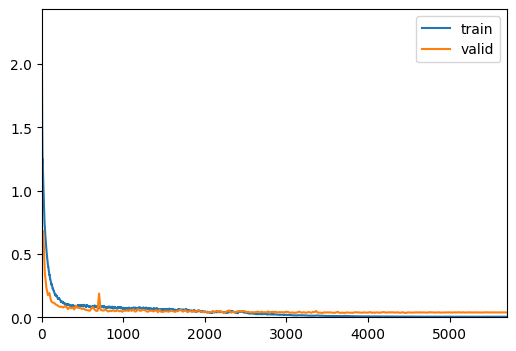

In [7]:
# What callbacks do we want
cbs = []
csv_append = True
if (start_epoch == 0):
    cbs.append(ShowGraphCallback())
    csv_append = False # overwrite whatever is there since we are starting at the beginning
    
# Add a logger to write to csv
cbs.append(CSVLogger(fname='history.csv', append=csv_append))

# Do the learning
learn_gen.fit_one_cycle(epocs,
                        pct_start=0.3,
                        wd=wd,
                        start_epoch=start_epoch,
                        cbs=cbs
                       )

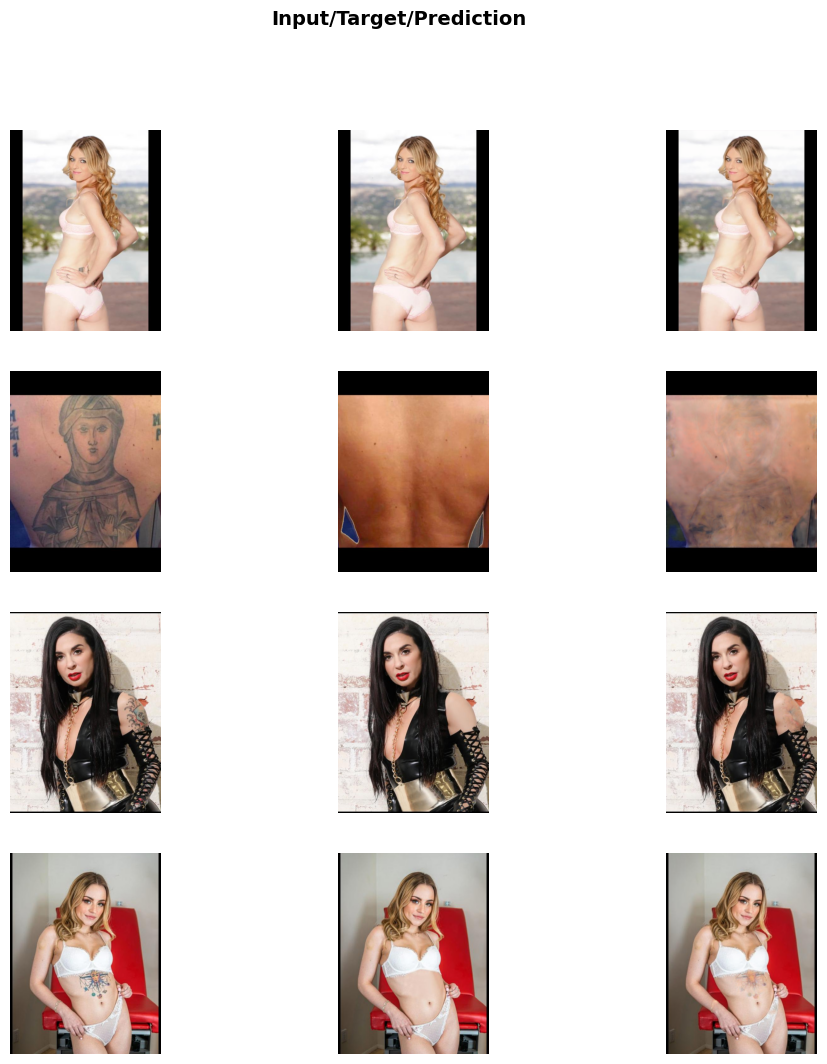

In [8]:
learn_gen.show_results(max_n=4, figsize=(12,12))

# Export the Model

In [9]:
#save the model
learn_gen.export(f'./deinked-{bbone.__name__}-epocs{epocs}.pkl')

# Quick test run

<AxesSubplot: >

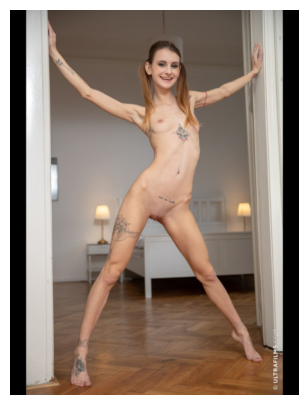

In [10]:
# Load a test file
img_fast_raw = PILImage.create("./data/test/0010-15.jpg")

resize = Resize(image_size, 
                 resamples=(Image.BILINEAR, Image.NEAREST),
                 method=ResizeMethod.Pad,
                 pad_mode=PadMode.Zeros)

img_fast = resize(img_fast_raw, split_idx=1)
img_fast.show()

In [11]:
# Run our prediction
tensor_image, img_hr_tensor_base, preds_tensor_base = learn_gen.predict(img_fast)

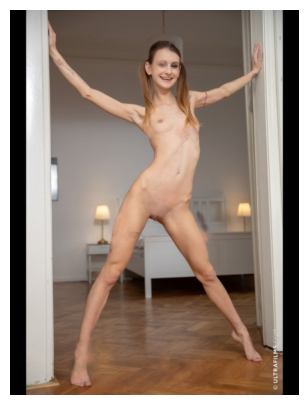

In [12]:
# Show our results
pil_image = PILImage.create(tensor_image)
pil_image.show()
pil_image.save("model-test.jpg")